In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    classification_report,
    confusion_matrix
)

from sklearnex import patch_sklearn

patch_sklearn()
sys.path.append("..")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

In [3]:
# !wandb offline

In [4]:
from src.modules.config.ml_dataset import smiles_to_fingerprint

In [5]:
current_dir = os.getcwd()
TRAIN = os.path.join(current_dir, "../data/processed/train.csv")
TEST = os.path.join(current_dir, "../data/processed/test.csv")
SMOTE = os.path.join(current_dir, "../data/processed/smote_data.csv")
ADASYN = os.path.join(current_dir, "../data/processed/adasyn_data.csv")

In [6]:
train_data = pd.read_csv(TRAIN)
test_data = pd.read_csv(TEST)

In [7]:
X_train = smiles_to_fingerprint(train_data["smiles"].tolist())
# X_train = train_data.drop(columns=["HIV_active"])
y_train = train_data["HIV_active"].values

X_test = smiles_to_fingerprint(test_data["smiles"].tolist())
y_test = test_data["HIV_active"].values

del train_data, test_data

[18:06:11] WARNING: not removing hydrogen atom without neighbors
[18:06:11] WARNING: not removing hydrogen atom without neighbors


In [8]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=42)
rf_model.fit(X_train, y_train)
model_params = rf_model.get_params()
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_test_probs = rf_model.predict_proba(X_test)

In [9]:
# wandb.init(project="MoleculeNet-HIV-rf", config=model_params)

In [10]:
# plot_class_proportions(y_train, y_test, "HIV_active")
# # plot_learning_curve(rf_model, X_train, y_train)
# plot_roc(y_test, y_test_probs, "HIV_active")
# plot_precision_recall(y_test, y_test_probs, "HIV_active")
# plot_feature_importances(rf_model)

# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()

In [9]:
proba_summary = {
    "min": y_test_proba_rf.min(),
    "max": y_test_proba_rf.max(),
    "mean": y_test_proba_rf.mean(),
    "std": y_test_proba_rf.std(),
    "num_close_to_1": np.sum(y_test_proba_rf > 0.99),
    "num_close_to_0": np.sum(y_test_proba_rf < 0.01),
}

print("Probabilities Summary:", proba_summary)

Probabilities Summary: {'min': np.float64(0.0), 'max': np.float64(0.91), 'mean': np.float64(0.02763298502114958), 'std': np.float64(0.05655102088488259), 'num_close_to_1': np.int64(0), 'num_close_to_0': np.int64(1698)}


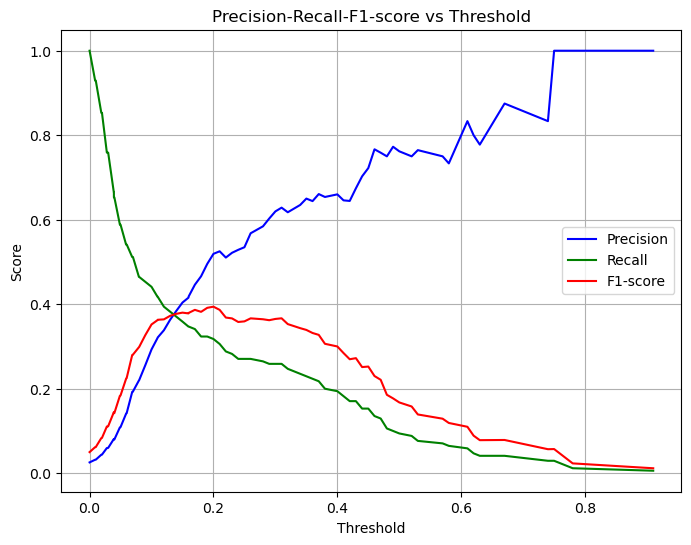

In [10]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba_rf)
f1_scores = 2 * (precision * recall) / (precision + recall)
plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds_pr, recall[:-1], label="Recall", color="green")
plt.plot(thresholds_pr, f1_scores[:-1], label="F1-score", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall-F1-score vs Threshold")
plt.legend(loc="best")
plt.grid()
plt.show()

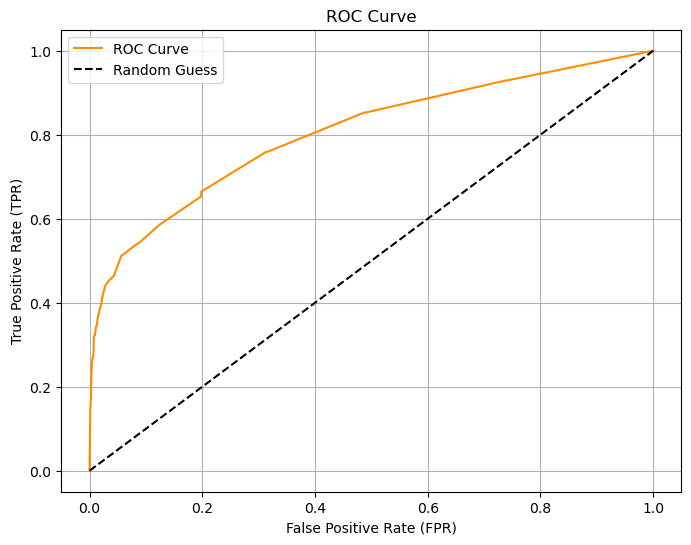

In [11]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()


In [12]:
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds_pr[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Make predictions using the new threshold
y_test_pred_optimal = (y_test_proba_rf >= optimal_threshold).astype(int)

Optimal Threshold: 0.2


In [13]:
print("Random Forest Test Classification Report (Optimal Threshold):")
print(classification_report(y_test, y_test_pred_optimal))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_optimal))

Random Forest Test Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6467
           1       0.52      0.32      0.39       170

    accuracy                           0.97      6637
   macro avg       0.75      0.65      0.69      6637
weighted avg       0.97      0.97      0.97      6637

Confusion Matrix:
[[6417   50]
 [ 116   54]]
